## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from utils import closest, IQR, scatterPlot_Type1, HYDRoSWOTUnitsConvertor, NHDPlusUnitsConvertor, Merge_Multiple_Files, Read_Multiple_Files
import os

## Import Datasets

#### 1) Dependent (Target) Variable

Source: [Canova et al., (2016)](https://www.sciencebase.gov/catalog/item/57435ae5e4b07e28b660af55)

In [2]:
# Reading HYDRoSWOT
Dep_var = pd.read_csv('./DataPreProcessing/Input/Depen/SWOT_ADCP_Dataset.csv', low_memory= False)

# Converting dataset units from imperical to metric
Dep_var = HYDRoSWOTUnitsConvertor(Dep_var)

#### 2) Independent (Predictive) Variables

Sources: [McKay et al., (2012)](https://nhdplus.com/NHDPlus/NHDPlusV2_documentation.php), [Wieczorek et al., (2018)](https://www.sciencebase.gov/catalog/item/5669a79ee4b08895842a1d47), [Abeshu et al., (2022)](https://essd.copernicus.org/articles/14/929/2022/), [Trabucco & Zomer, (2019)](https://figshare.com/articles/dataset/Global_Aridity_Index_and_Potential_Evapotranspiration_ET0_Climate_Database_v2/7504448/3).

In [3]:
# Reading Gauges
Gauge = pd.read_csv('./DataPreProcessing/Input/Indepen_gauge/NHDPlus_Gages.txt', low_memory= False)
Gauge.rename(columns = {'FLComID':'COMID'}, inplace = True)

In [4]:
# Reading Reaches
directory = './DataPreProcessing/Input/Indepen_reaches' 
dfs = Read_Multiple_Files(directory, '.txt')

# Merging datasets
Indep_var_reaches = Merge_Multiple_Files(dfs, 'COMID')

# Calculate percentage of developed, forest, agriculture types of land cover 
Indep_var_reaches["NLCD_Developed_%"] = Indep_var_reaches["CAT_NLCD16_21"]+ Indep_var_reaches["CAT_NLCD16_22"]+ Indep_var_reaches["CAT_NLCD16_23"]+ Indep_var_reaches["CAT_NLCD16_24"]
Indep_var_reaches["NLCD_Forest_%"] = Indep_var_reaches["CAT_NLCD16_41"]+ Indep_var_reaches["CAT_NLCD16_42"]+ Indep_var_reaches["CAT_NLCD16_43"]
Indep_var_reaches["NLCD_Agriculture_%"] = Indep_var_reaches["CAT_NLCD16_81"]+ Indep_var_reaches["CAT_NLCD16_82"]

# Convert units from imperical to metric in discharge fields (QE, QC, QA)
Indep_var_reaches = NHDPlusUnitsConvertor(Indep_var_reaches)

# Exclude required fields
Indep_var_reaches = Indep_var_reaches[[ "COMID", "REACHCODE","FTYPE","StreamOrde_y","TotDASqKM_y", 
                                        "MINELEVSMO", "SLOPE", "QA_cms", "QC_cms", "QE_cms",
                                        "CAT_EVI_OND_2011", "CAT_EVI_AMJ_2012", "CAT_EVI_JAS_2012", "CAT_EVI_JFM_2012",
                                        "ACC_NDAMS2010", "CAT_POPDENS10", "NLCD_Developed_%", "NLCD_Forest_%", "NLCD_Agriculture_%",
                                        "CAT_SILTAVE", "CAT_CLAYAVE", "CAT_SANDAVE", "D50_mm_", "Mean_AI"]]

# Excluding reaches which are not 'StreamRiver', 'ArtificialPath', or 'CanalDitch'
Indep_var_reaches = Indep_var_reaches[Indep_var_reaches['FTYPE'].isin(['StreamRiver' , 'ArtificialPath', 'CanalDitch'])]
               
# Removing Nan values
Indep_var_reaches = Indep_var_reaches.dropna(axis=0, how='any')

# Export Independent variables for reaches categorized as 'StreamRiver', 'ArtificialPath', and 'Canalditch' across CONUS
Indep_var_reaches.to_csv("./DataPreProcessing/Output/indep_var_reaches_CONUS.txt")

In [5]:
# Joining reaches and gauges
Indep_var_gauge = pd.merge(Gauge, Indep_var_reaches, how="left", on="COMID")
Indep_var_gauge.rename(columns = {'SOURCE_FEA':'site_no'}, inplace = True)

# Export Independent variables for gauges categorized as 'StreamRiver', 'ArtificialPath', and 'Canalditch' across CONUS
Indep_var_gauge.to_csv("./DataPreProcessing/Output/indep_var_gauges_CONUS.txt")

## Joining dependent and independent variables  

In [6]:
df_joint = pd.merge(Dep_var, Indep_var_gauge, how="left", on="site_no")

print("Site ID with number of observations per each site:")
print(df_joint['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df_joint.shape[0])
print("Total number of site is", len(df_joint['site_no'].value_counts()))
print("Average number of observations per site is", round(df_joint['site_no'].value_counts().mean(),0))                             

Site ID with number of observations per each site:
11337080    1895
11304810    1686
11337190    1449
11447850    1270
11312676    1138
            ... 
9073300        1
9107000        1
9111700        1
9113500        1
66666609       1
Name: site_no, Length: 10081, dtype: int64
-----------------------------------------------------
Total number of observations is 223022
Total number of site is 10081
Average number of observations per site is 22.0


## Filtration process 

#### 1) Delete Null values in candidate columns

In [7]:
candidate_columns = ['site_no', 'drain_area_va', 'q_va', 'stream_wdth_va', 'mean_vel_va', 'mean_depth_va', 'QE_cms']
df = df_joint.dropna(axis=0, how='any', subset=candidate_columns)

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000    155
6813500    145
6610000    140
6807000    134
6601200    132
          ... 
6449100      1
2336526      1
9314500      1
6445980      1
6142400      1
Name: site_no, Length: 4802, dtype: int64
-----------------------------------------------------
Total number of observations is 44303
Total number of site is 4802
Average number of observations per site is 9.0


#### 2) Delete zero and negative values in q, w, mean d, mean V, and max V from dataset

In [8]:
candidate_columns = ['q_va', 'stream_wdth_va', 'mean_depth_va', 'mean_vel_va',  'max_vel_va']
df = df[(df[candidate_columns] > 0).all(axis=1)]
    
print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000     155
6813500     144
6610000     138
6601200     131
6486000     130
           ... 
10131000      1
2160000       1
10133650      1
10133800      1
1616100       1
Name: site_no, Length: 4763, dtype: int64
-----------------------------------------------------
Total number of observations is 43434
Total number of site is 4763
Average number of observations per site is 9.0


#### 3) Delete sites which are not ST(STREAM)

In [9]:
df = df.loc[(df['site_tp_cd'] == 'ST')]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000     155
6813500     144
6610000     138
6601200     131
6486000     130
           ... 
3438000       1
7010022       1
5130500       1
9353800       1
11172175      1
Name: site_no, Length: 4736, dtype: int64
-----------------------------------------------------
Total number of observations is 43088
Total number of site is 4736
Average number of observations per site is 9.0


#### 4) Delete obseravtions with dmax<dmean

In [10]:
df = df[(df['max_depth_va'] > df['mean_depth_va'])]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000    155
6813500    144
6610000    138
6601200    131
6486000    130
          ... 
9371010      1
7109500      1
2198690      1
9383400      1
7047855      1
Name: site_no, Length: 4684, dtype: int64
-----------------------------------------------------
Total number of observations is 41292
Total number of site is 4684
Average number of observations per site is 9.0


#### 5) Delete obseravtions with Vmax<Vmean

In [11]:
df = df[(df['max_vel_va'] > df['mean_vel_va'])]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000      155
6813500      143
6610000      137
6601200      131
6486000      130
            ... 
10311300       1
10311400       1
10312000       1
214253361      1
3221000        1
Name: site_no, Length: 4683, dtype: int64
-----------------------------------------------------
Total number of observations is 41236
Total number of site is 4683
Average number of observations per site is 9.0


#### 6) Delete obseravtions with qva>1.05_q_meas and qva>0.95_q_meas

In [12]:
df = df[(df['q1_Outside5Percent'] == 0)]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000     153
6813500     143
6610000     137
6601200     130
6486000     130
           ... 
6216900       1
3025000       1
6224000       1
10125800      1
3095500       1
Name: site_no, Length: 4622, dtype: int64
-----------------------------------------------------
Total number of observations is 38567
Total number of site is 4622
Average number of observations per site is 8.0


#### 7) Delete obseravtions with qva>1.05(A.v) and qva>0.95(A.v)

In [13]:
df = df[(df['q2_q_va_OutsideBounds'] == 0)]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000     153
6813500     142
6610000     137
6601200     130
6486000     130
           ... 
3042280       1
10075000      1
10079500      1
6192500       1
9503300       1
Name: site_no, Length: 4607, dtype: int64
-----------------------------------------------------
Total number of observations is 38194
Total number of site is 4607
Average number of observations per site is 8.0


#### 8) Delete obseravtions with q_meas>1.05(A.v) and q_meas>0.95(A.v)

In [14]:
df = df[(df['q2_meas_q_va_OutsideBounds'] == 0)]

print("Site ID with number of observations per each site:")
print(df['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df.shape[0])
print("Total number of site is", len(df['site_no'].value_counts()))
print("Average number of observations per site is", round(df['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6893000     153
6813500     142
6610000     137
6486000     130
6601200     130
           ... 
6151500       1
3042280       1
10075000      1
10079500      1
3117500       1
Name: site_no, Length: 4607, dtype: int64
-----------------------------------------------------
Total number of observations is 38191
Total number of site is 4607
Average number of observations per site is 8.0


## Identification Process

#### 1) Mean-flow Condition

In [15]:
df_mf = pd.DataFrame()

for idx, site_obs in enumerate(df['site_no'].value_counts()[:]):
    df_plt_mf = df[df["site_no"] == df['site_no'].value_counts().index[idx]]
    Q_mf_selected = closest(df_plt_mf['q_va'].tolist(), df_plt_mf['QE_cms'].tolist()[0])
    df_mf = pd.concat([df_mf, df_plt_mf[(df_plt_mf['q_va'] == Q_mf_selected)]])
    
df_mf = df_mf.loc[:, ['site_no', 'q_va', 'stream_wdth_va', 'mean_depth_va', 'q8_stream_width_D_mean_depth']]
df_mf.rename(columns = {'q_va':'q_va_mf', 'stream_wdth_va':'stream_wdth_va_mf', 'mean_depth_va':'mean_depth_va_mf', 'q8_stream_width_D_mean_depth':'q8_stream_width_D_mean_depth_mf'}, inplace = True)
df_mf.head()

,site_no,q_va_mf,stream_wdth_va_mf,mean_depth_va_mf,q8_stream_width_D_mean_depth_mf
124802,6893000,1755.166393,307.887624,4.614672,66.72
121650,6813500,1330.889647,247.192800,4.602480,53.71
119451,6610000,1063.751778,194.807738,5.000244,38.96
118010,6486000,878.005088,163.380420,4.705502,34.72
118741,6601200,932.383512,189.474043,4.477512,42.32


#### 2) Bankfull Condition

In [16]:
df_bnk= pd.DataFrame()

for idx, site_obs in enumerate(df['site_no'].value_counts()[:]):
    df_plt_bnk = df[df["site_no"] == df['site_no'].value_counts().index[idx]]
    df_plt_bnk1 = df_plt_bnk.loc[(df_plt_bnk['stream_wdth_va'] < IQR(df_plt_bnk["stream_wdth_va"])[1]) & (df_plt_bnk['stream_wdth_va'] > IQR(df_plt_bnk["stream_wdth_va"])[0])]
    df_bnk= pd.concat([df_bnk, df_plt_bnk1.query('q_va == q_va.max()') ])
    
df_bnk = df_bnk.loc[:, ['site_no', 'q_va', 'stream_wdth_va', 'mean_depth_va', 'q8_stream_width_D_mean_depth']]
df_bnk.rename(columns = {'q_va':'q_va_bnk', 'stream_wdth_va':'stream_wdth_va_bnk', 'mean_depth_va':'mean_depth_va_bnk', 'q8_stream_width_D_mean_depth':'q8_stream_width_D_mean_depth_bnk'}, inplace = True)
df_bnk.head()    

,site_no,q_va_bnk,stream_wdth_va_bnk,mean_depth_va_bnk,q8_stream_width_D_mean_depth_bnk
124653,6893000,6709.351312,335.913984,10.073640,33.35
121878,6813500,3319.836661,247.563437,7.768625,31.87
119486,6610000,1922.710788,207.873600,6.004560,34.62
117550,6486000,1568.750775,168.859200,7.010400,24.09
118351,6601200,1599.899256,176.479200,6.096000,28.95


## Visualization of within channel, mean-flow, bankfull, and overbank observations

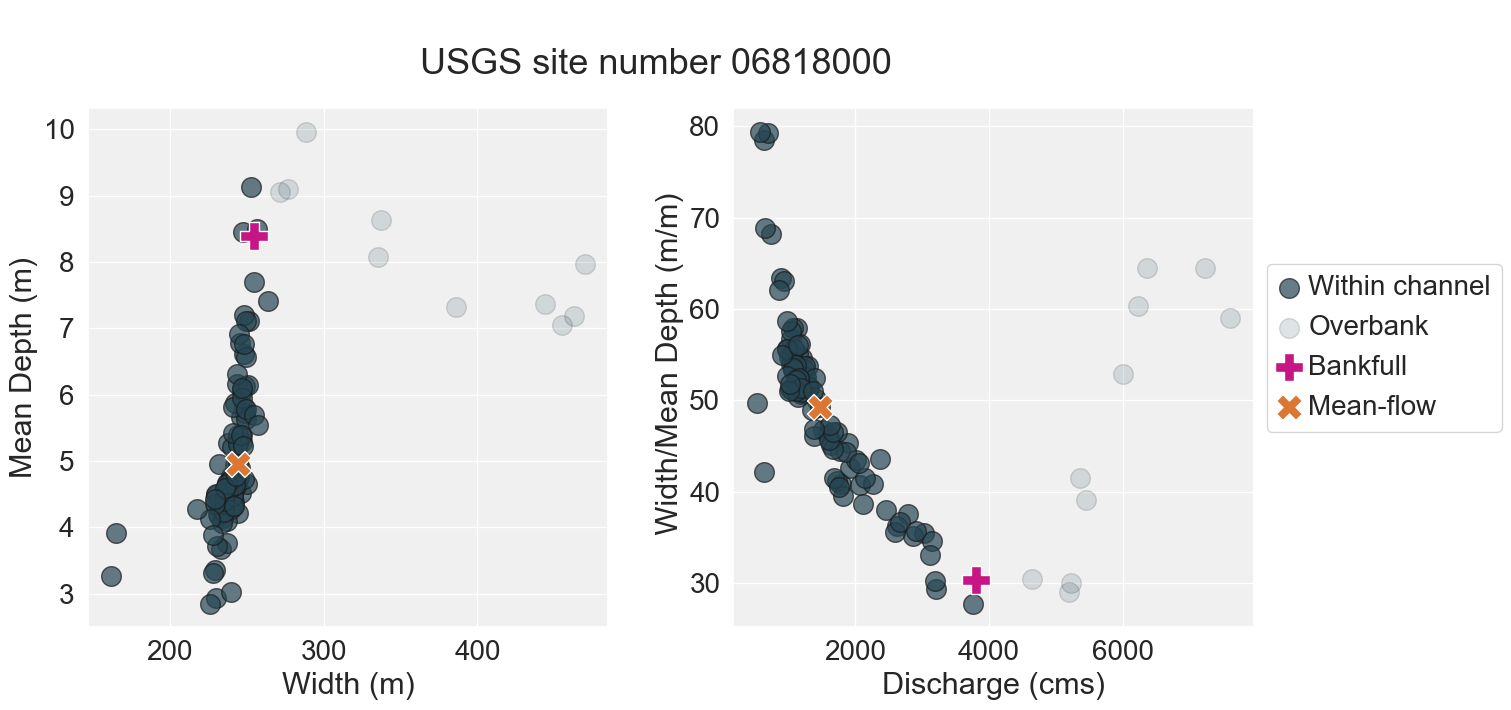

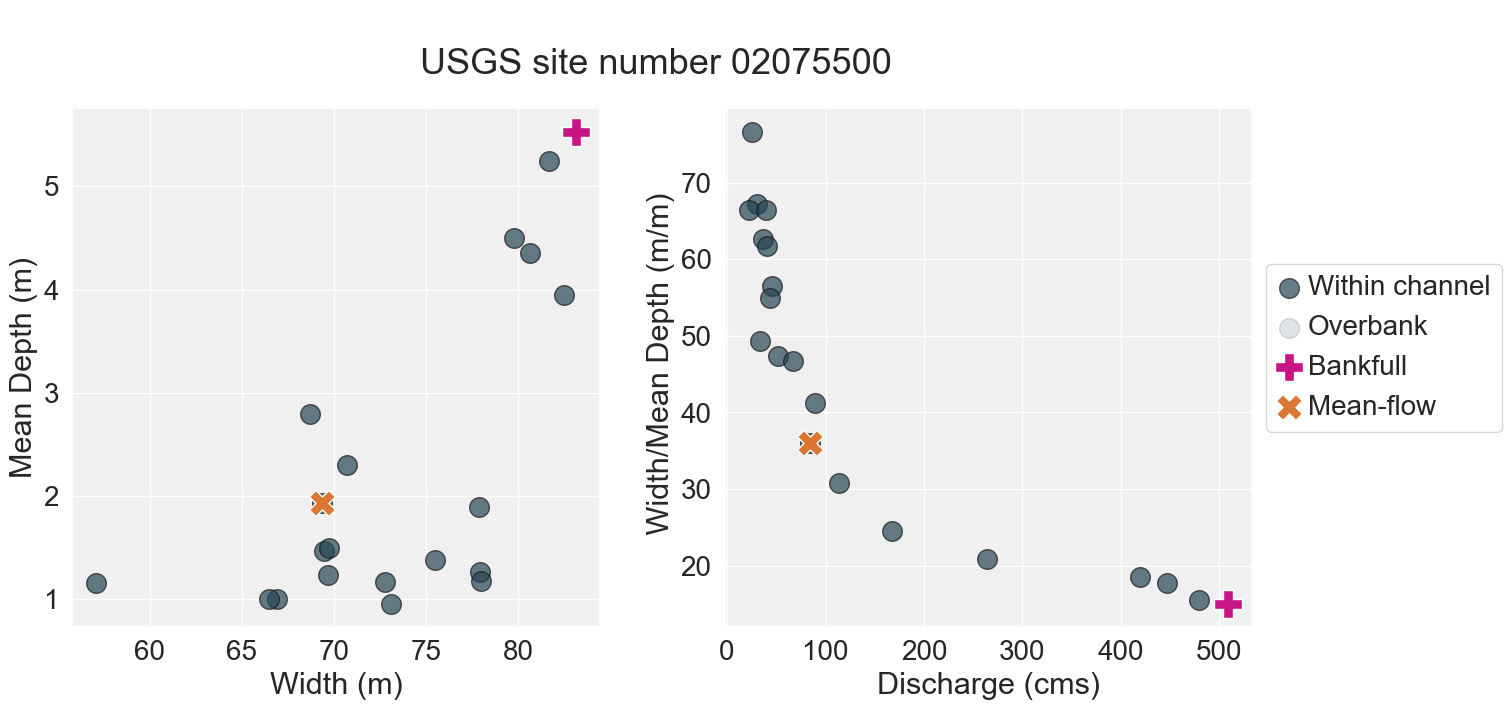

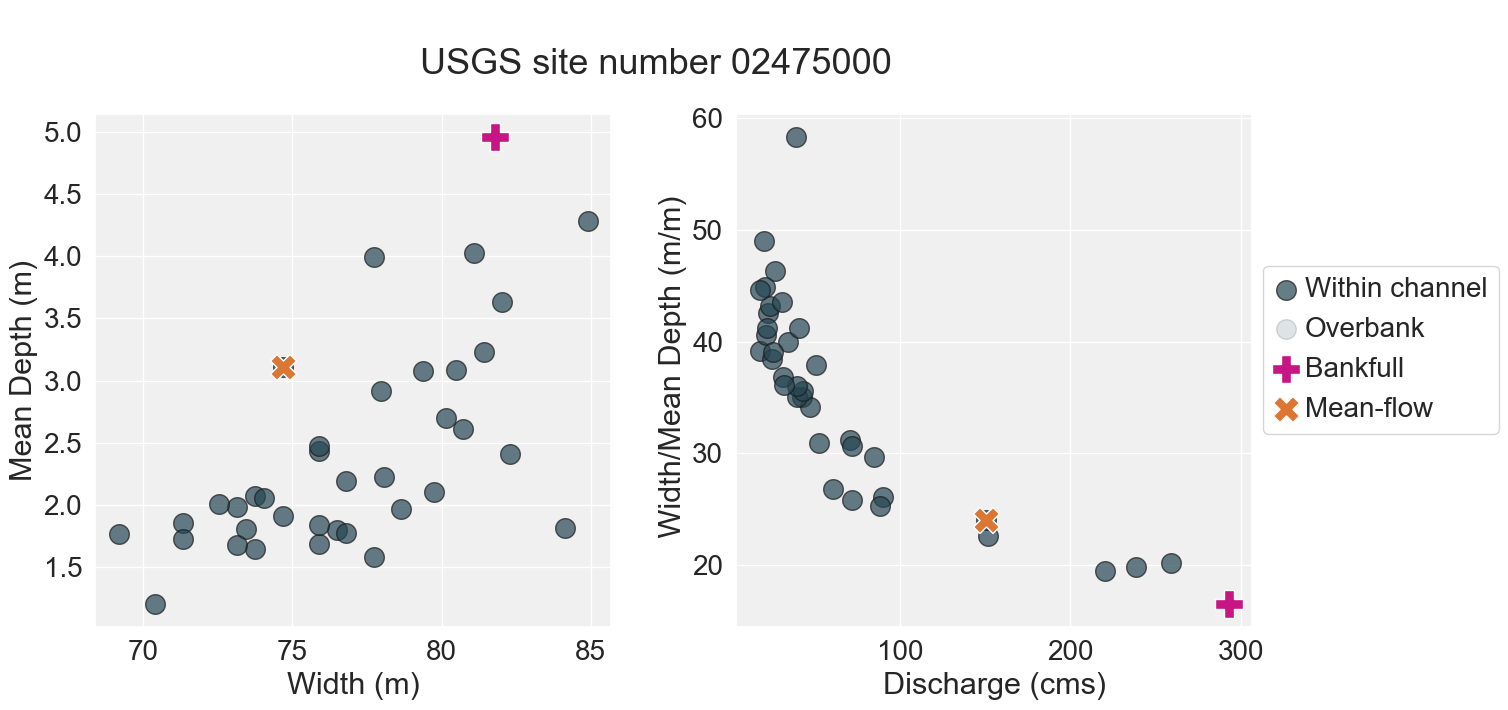

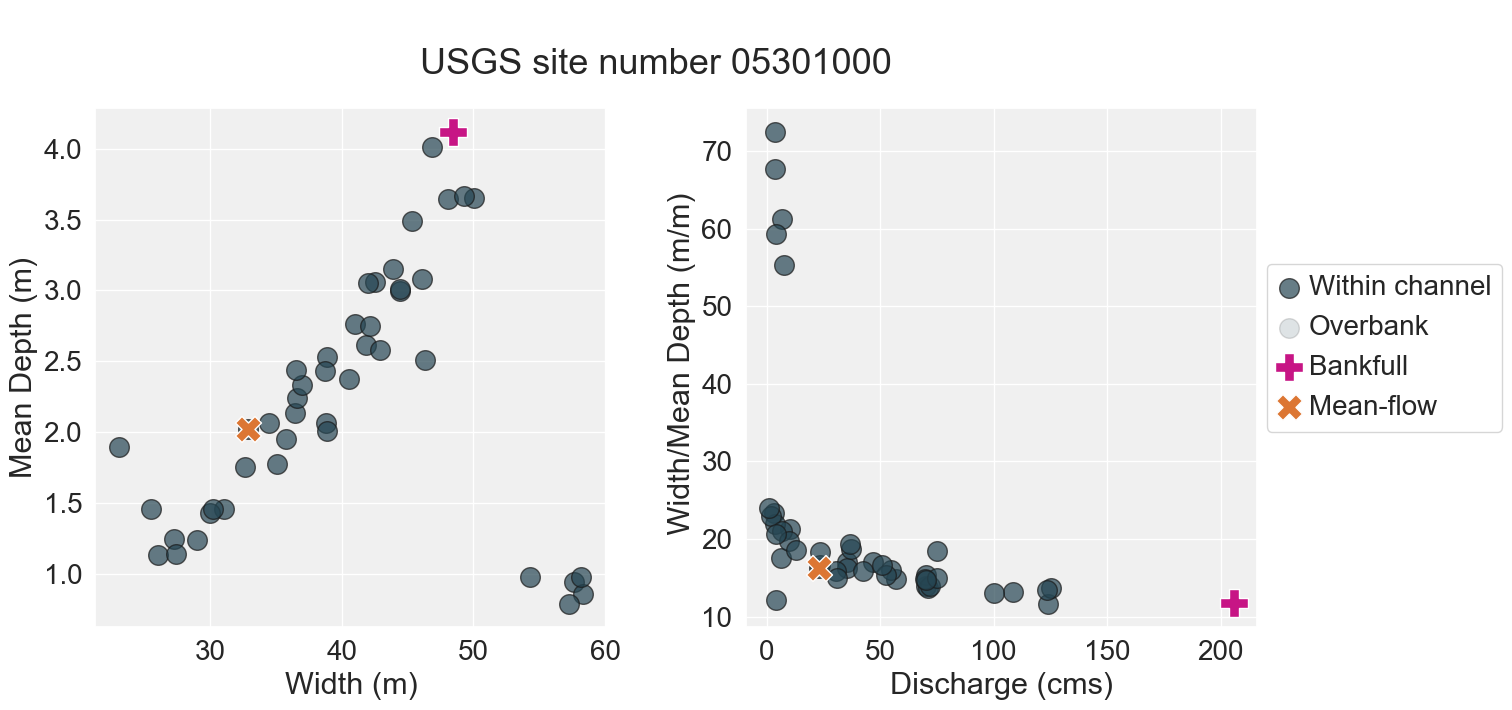

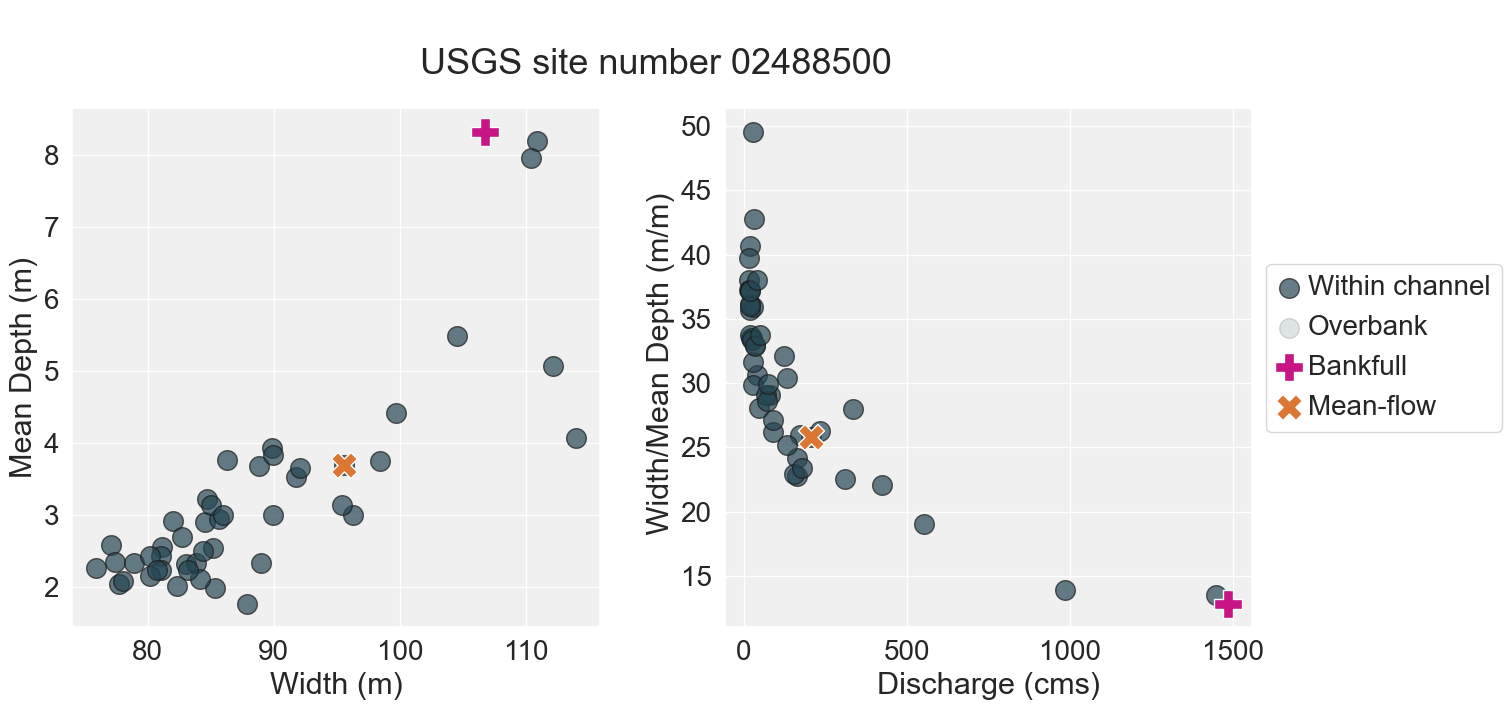

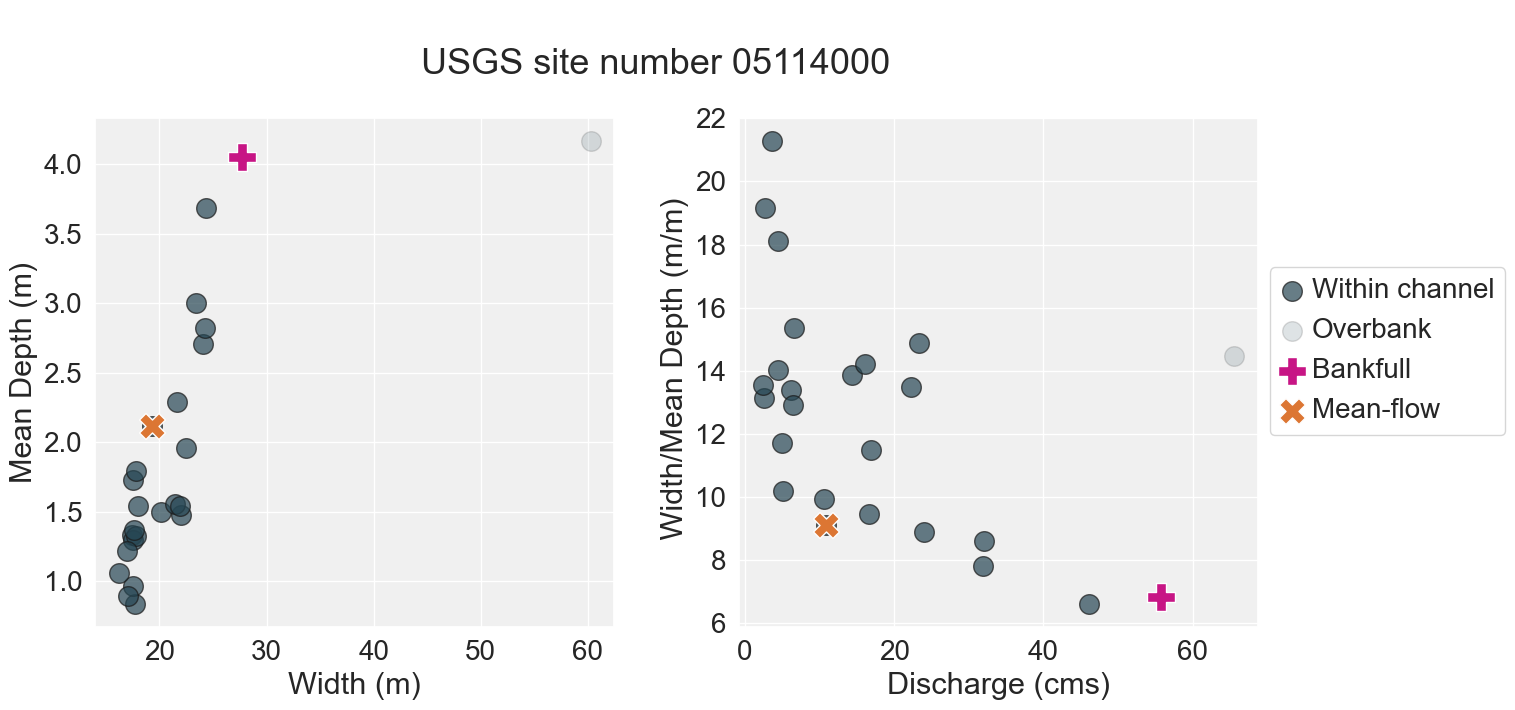

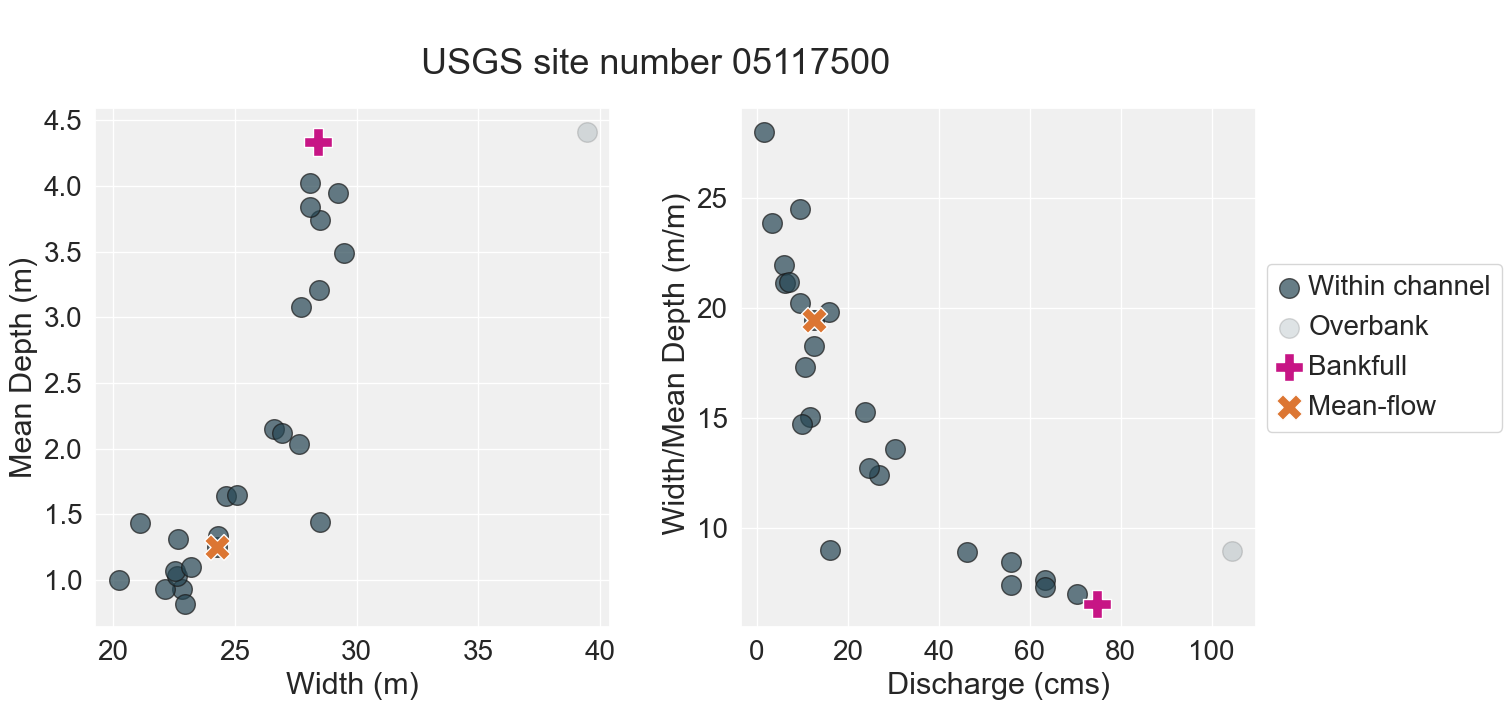

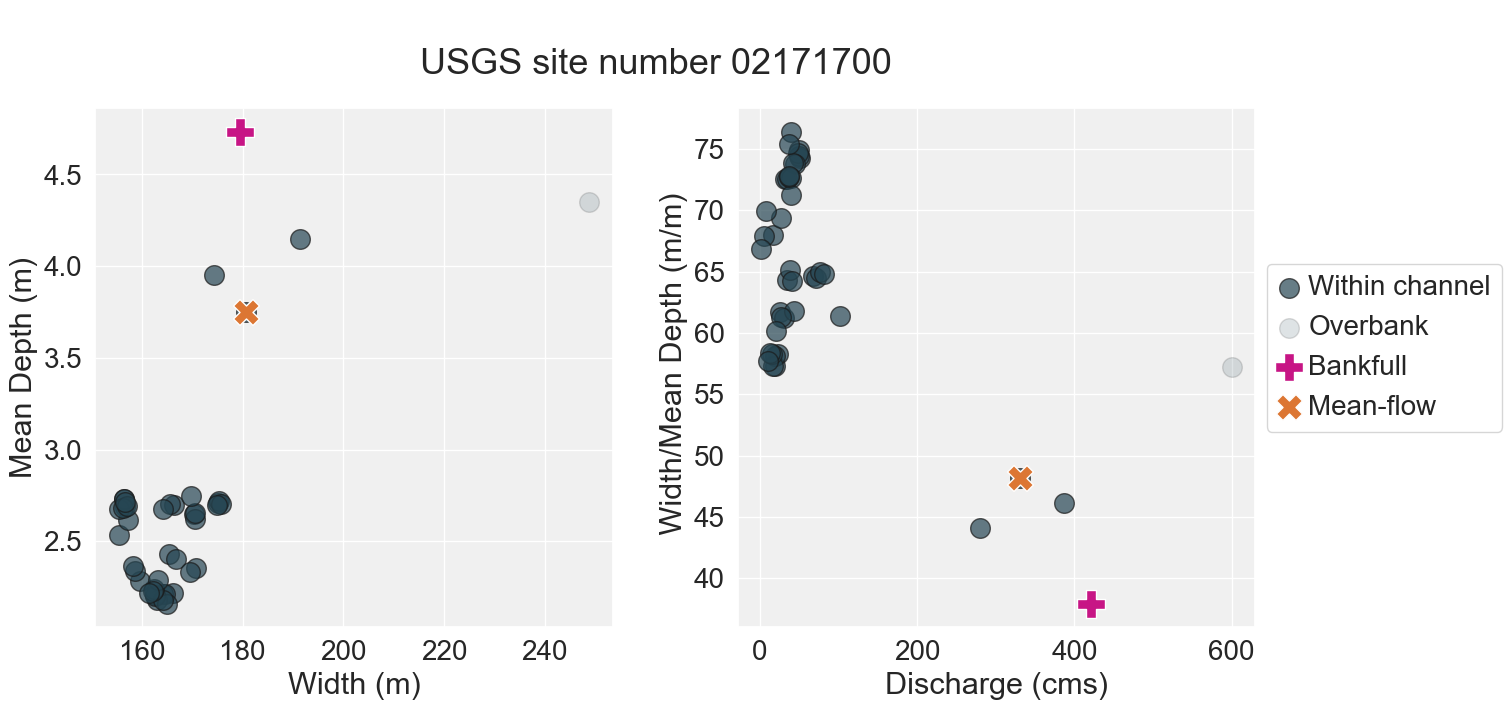

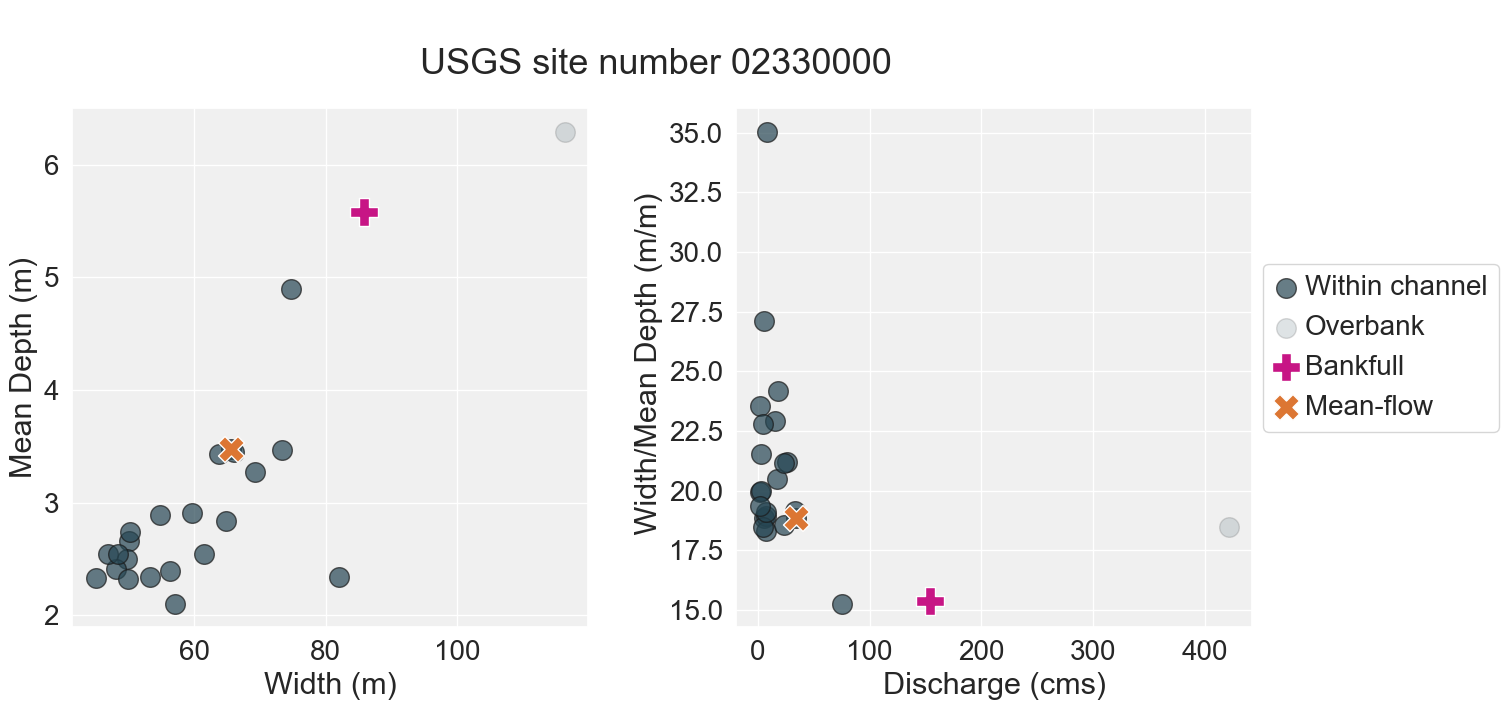

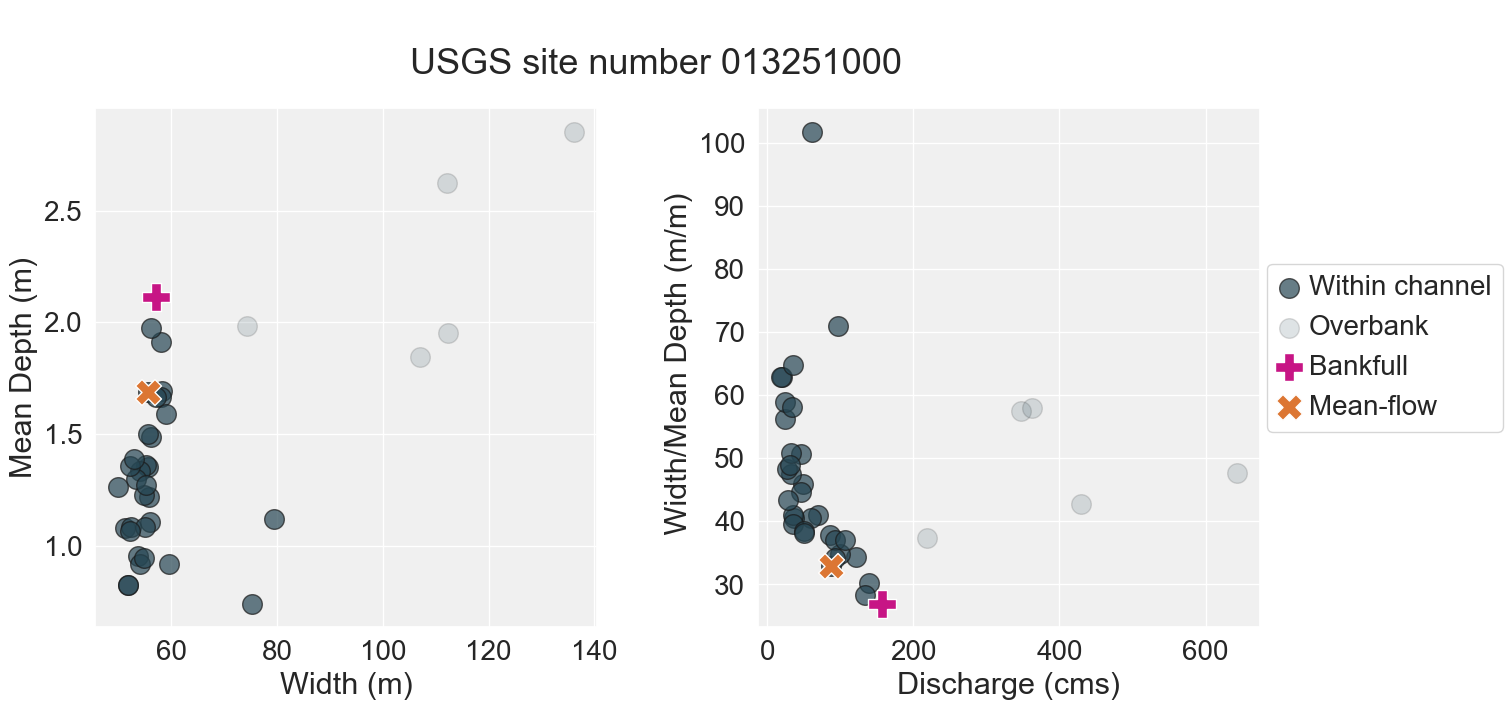

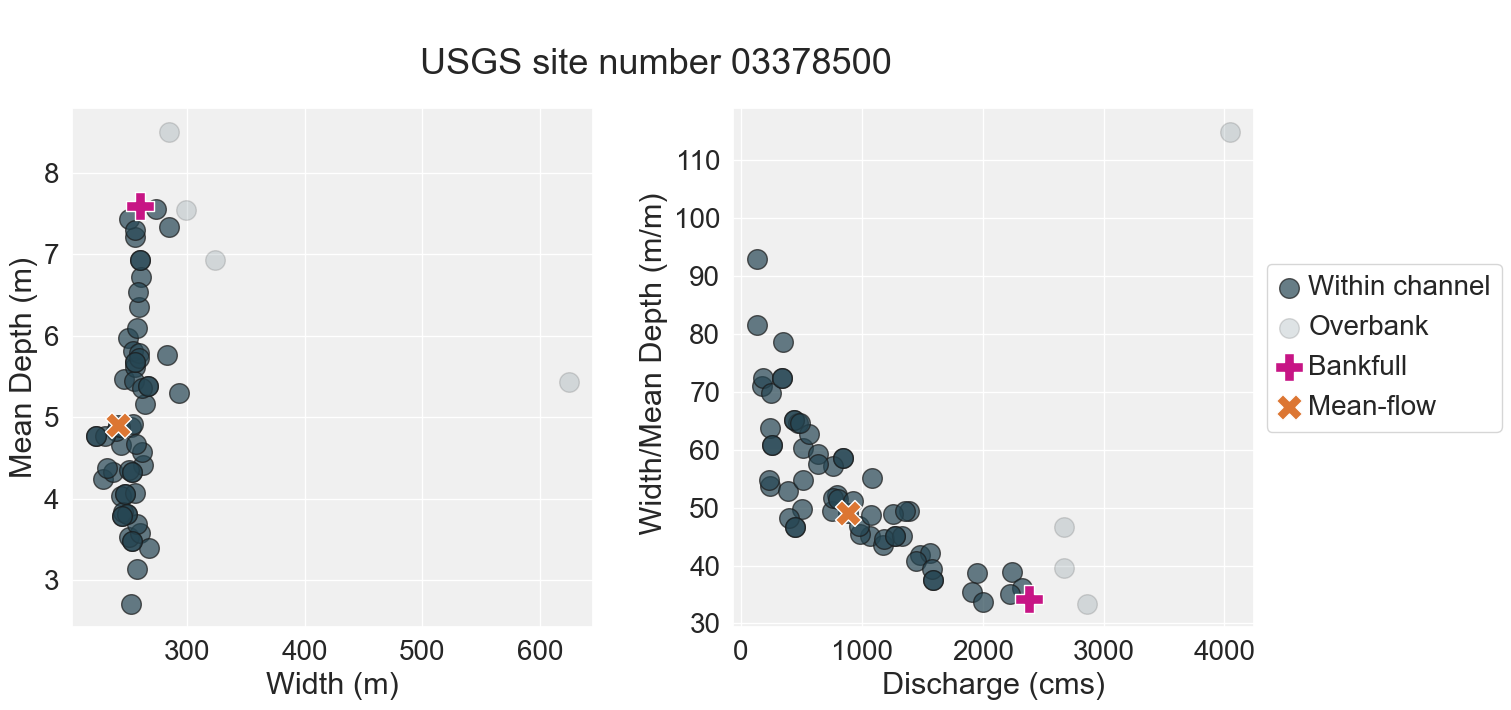

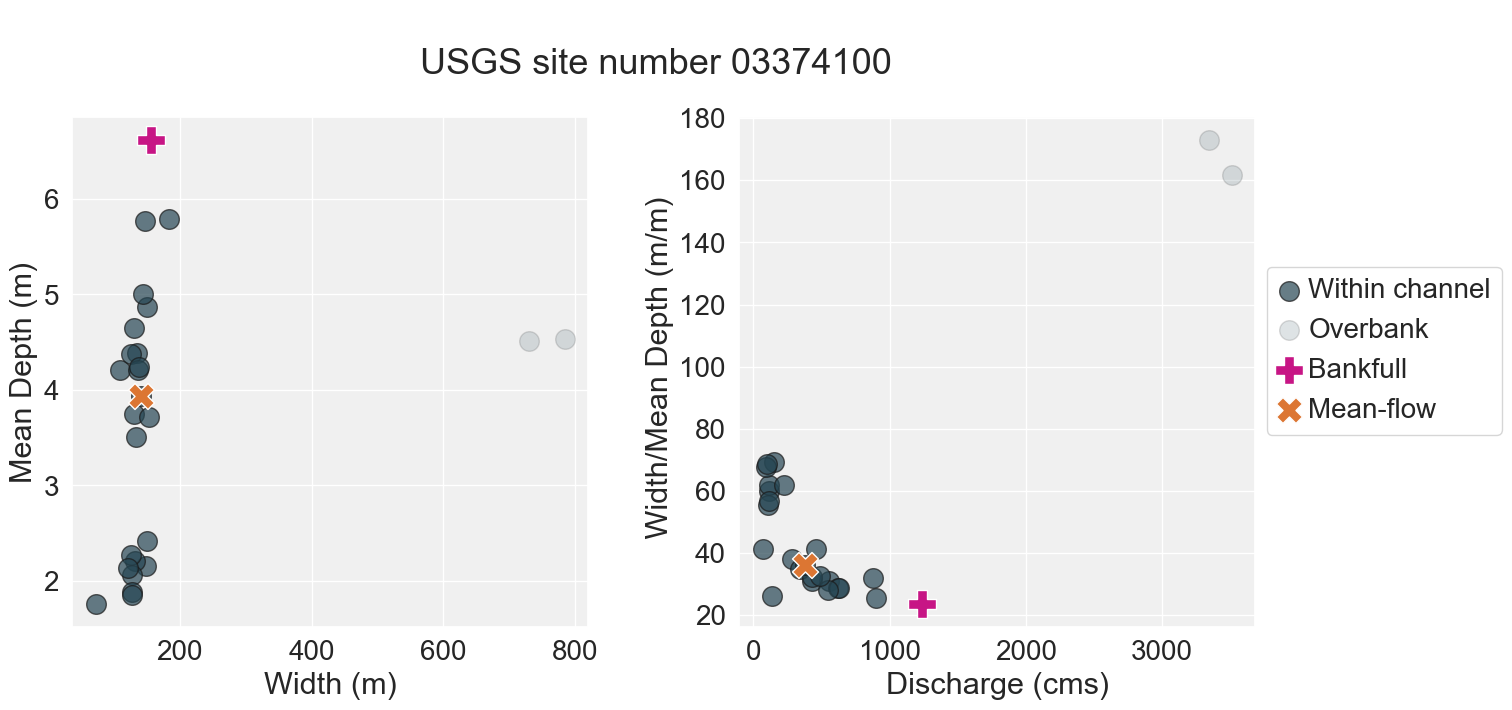

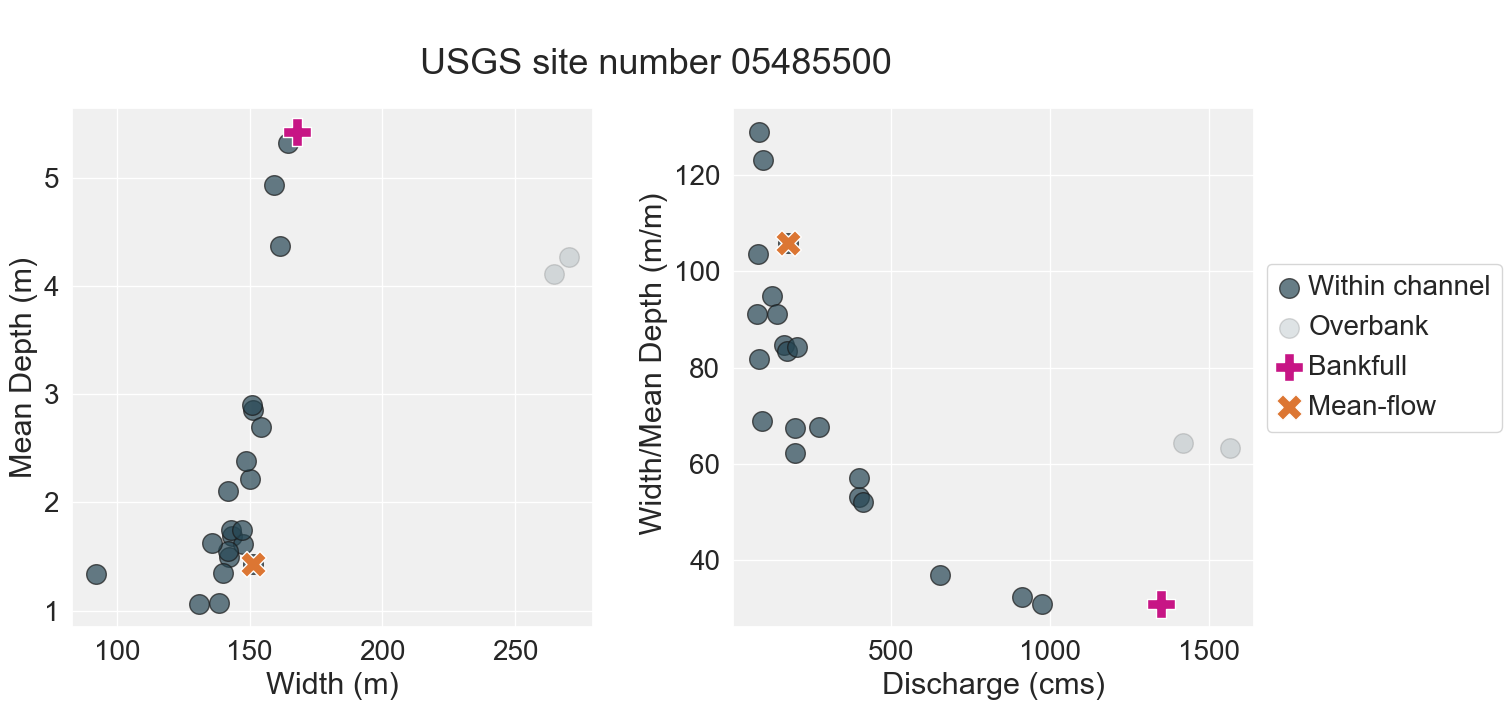

In [21]:
sites = [6818000, 2075500, 2475000, 5301000, 2488500, 5114000, 5117500, 2171700, 2330000, 13251000, 3378500, 3374100, 5485500]

for i in range(0, len(sites)):
    scatterPlot_Type1(df, df_bnk, df_mf, sites[i])

## Final dataset

In [17]:
df_indep= df_joint.loc[:, ['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va', 'REACHCODE_x', 'COMID', 'FTYPE',
                           'CAT_EVI_OND_2011', 'CAT_EVI_AMJ_2012', 'CAT_EVI_JAS_2012', 'CAT_EVI_JFM_2012',
                           'ACC_NDAMS2010', 'CAT_POPDENS10', 'StreamOrde_y', 'TotDASqKM_y', 'Mean_AI',
                           'D50_mm_', 'MINELEVSMO', 'SLOPE', 'NLCD_Developed_%', 'NLCD_Forest_%', 'NLCD_Agriculture_%',
                           'QA_cms', 'QC_cms', 'QE_cms', 'CAT_SILTAVE', 'CAT_SANDAVE', 'CAT_CLAYAVE']]

In [18]:
# Adding datasets for mean-flow and bankfull conditons to the primary dataset (df)
df_Final = Merge_Multiple_Files([df_mf, df_bnk, df_indep], 'site_no')

# Removing duplicates
df_Final= df_Final.drop_duplicates()

# Removing Nan values
df_Final = df_Final.dropna(axis=0, how='any')

# Removing zeros and negative values 
candidate_columns = df_Final.drop(columns=['site_no','station_nm', 'dec_lat_va', 'dec_long_va', 'REACHCODE_x', 'COMID', 'FTYPE', 'q8_stream_width_D_mean_depth_mf', 'q8_stream_width_D_mean_depth_bnk']).columns
df_Final = df_Final[(df_Final[candidate_columns] > 0).all(axis=1)]

## Removing duplicates
df_plt_n= pd.DataFrame()
for idx, site_obs in enumerate(df_Final['site_no'].value_counts()[:]):
    df_plt = df_Final[df_Final["site_no"] == df_Final['site_no'].value_counts().index[idx]]
    if df_plt['site_no'].value_counts().item() > 1:
        df_plt= df_plt.query('stream_wdth_va_mf == stream_wdth_va_mf.max() & stream_wdth_va_bnk == stream_wdth_va_bnk.max()')
    df_plt_n= pd.concat([df_plt, df_plt_n])
df_plt_n= df_plt_n.drop_duplicates(subset=['site_no'])

print("Site ID with number of observations per each site:")
print(df_plt_n['site_no'].value_counts())
print("-----------------------------------------------------")
print("Total number of observations is", df_plt_n.shape[0])
print("Total number of site is", len(df_plt_n['site_no'].value_counts()))
print("Average number of observations per site is", round(df_plt_n['site_no'].value_counts().mean(),0))

Site ID with number of observations per each site:
6295000     1
6026210     1
6340000     1
6351200     1
6353000     1
           ..
6610000     1
6934500     1
5301000     1
10171000    1
1582500     1
Name: site_no, Length: 2626, dtype: int64
-----------------------------------------------------
Total number of observations is 2626
Total number of site is 2626
Average number of observations per site is 1.0


## Descriptive Statistics of Final dataset

In [24]:
df_plt_n.describe().style

,site_no,q_va_mf,stream_wdth_va_mf,mean_depth_va_mf,q8_stream_width_D_mean_depth_mf,q_va_bnk,stream_wdth_va_bnk,mean_depth_va_bnk,q8_stream_width_D_mean_depth_bnk,dec_lat_va,dec_long_va,REACHCODE_x,COMID,CAT_EVI_OND_2011,CAT_EVI_AMJ_2012,CAT_EVI_JAS_2012,CAT_EVI_JFM_2012,ACC_NDAMS2010,CAT_POPDENS10,StreamOrde_y,TotDASqKM_y,Mean_AI,D50_mm_,MINELEVSMO,SLOPE,NLCD_Developed_%,NLCD_Forest_%,NLCD_Agriculture_%,QA_cms,QC_cms,QE_cms,CAT_SILTAVE,CAT_SANDAVE,CAT_CLAYAVE
count,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000,2626.000000
mean,6266709.712871,113.649920,55.081710,1.572541,37.140278,329.524100,63.624916,2.535405,25.860141,39.416794,-88.668234,6708705746587.765625,17648947.342346,0.235514,0.389117,0.407068,0.194912,248.559779,215.471451,4.791318,19110.910650,0.790113,1.349224,24842.298553,0.001798,22.942064,29.780396,25.680388,107.145682,101.104970,109.323915,43.435674,33.254931,23.308503
std,21876745.933559,778.649784,90.537507,1.617998,32.221288,1670.381514,93.840983,2.016379,22.378026,4.633334,11.926717,4412176283104.879883,81075264.686757,0.057466,0.094684,0.094279,0.057788,1955.865090,442.139598,1.347398,138658.007938,0.234803,3.151716,32354.425941,0.004258,25.512572,25.150866,24.615152,714.174192,681.978870,739.426347,13.634876,19.860031,11.244712
min,1011000.000000,0.023333,3.352800,0.194462,3.530000,0.406488,3.779520,0.298704,1.490000,27.162500,-124.070652,1010002000001.000000,12932.000000,0.010000,0.020000,0.020000,0.010000,1.000000,0.010000,1.000000,4.337100,0.073500,0.029313,3.000000,0.000010,0.030000,0.010000,0.010000,0.000170,0.000170,0.000170,4.130000,3.040000,2.130000
25%,2224610.000000,5.657966,19.379870,0.734263,17.750000,20.519274,23.795431,1.274445,13.175000,36.342431,-94.703780,3060201000280.250000,4943824.000000,0.200000,0.330000,0.350000,0.160000,5.000000,7.600000,4.000000,425.234700,0.706670,0.299251,8950.000000,0.000091,5.190000,7.132500,3.965000,4.012738,4.455960,4.535191,36.132500,18.260000,15.770000
50%,4177860.000000,14.200564,32.221018,1.133856,28.205000,58.332369,39.624000,1.991258,20.330000,39.980149,-87.745151,5135152500020.000000,9052463.000000,0.230000,0.400000,0.420000,0.190000,16.000000,35.155000,5.000000,1255.079250,0.807210,0.565709,18827.500000,0.000699,10.745000,23.580000,17.650000,11.911080,12.591604,12.543706,45.350000,29.330000,23.295000
75%,6911797.500000,42.758370,58.697241,1.795196,45.647500,178.107397,68.832908,3.111246,31.682500,42.442917,-80.143552,10250017000163.500000,14786222.000000,0.270000,0.460000,0.480000,0.230000,63.000000,187.675000,6.000000,4328.564625,0.917016,1.253548,27192.250000,0.001876,31.120000,48.287500,42.717500,42.703626,43.298888,43.612574,53.400000,44.597500,30.747500
max,818999010.000000,18228.618144,2124.456000,27.909926,459.120000,33195.434911,1816.608000,27.859939,470.250000,48.996389,-67.247500,18060005004044.000000,948060170.000000,0.430000,0.620000,0.610000,0.440000,41971.000000,4478.560000,10.000000,2881390.387500,2.505550,89.274810,269497.000000,0.088030,99.920000,96.850000,95.310000,18165.071448,17329.820708,19022.008355,77.240000,92.800000,68.360000


## Split dataset into 2 training and testing datasets

In [25]:
train_set, test_set = train_test_split(df_plt_n, test_size=0.25, random_state=42, shuffle=True)

print("Total number of training dataset is", len(train_set['site_no'].value_counts()))
print("Total number of testing dataset is", len(test_set['site_no'].value_counts()))

Total number of training dataset is 1969
Total number of testing dataset is 657


## Export datasets for model developement

In [27]:
df_plt_n.to_csv("./DataPreProcessing/Output/df_Final.csv")
train_set.to_csv("./DataPreProcessing/Output/df_Train.csv")
test_set.to_csv("./DataPreProcessing/Output/df_Test.csv")